In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tqdm import tqdm


# Question 1

In [2]:
# get_freq is a function to get the distribution of pixel intensities in the image
def get_freq(img):
    # For each value of intensity in [0,255], we obtain the number of pixels with that intensity
    counts = dict(pd.Series(img.flatten()).value_counts())
    ret = np.array([counts[i] if i in counts else 0 for i in range(256)])
    return ret

# get_otsu_threshold is a function to compute the value of threshold of an image
def get_otsu_threshold(img):
    freq = get_freq(img)
    max_sigb2 = 0.
    uT = np.mean(np.arange(256)*freq)
    T_star = 0
    # We iterate through all possible gray levels and find the intensity which gives the maximum between-class variance.
    for i in range(1,255):
        # Compute mean 
        u1 = np.mean(np.arange(i)*freq[:i])
        u2 = np.mean(np.arange(i,256)*freq[i:])
        N1 = np.sum(freq[:i])
        N2 = np.sum(freq[i:])
        # Compute between class variance for each pixel intensity
        sigb2 = (((u1-uT)**2)*N1 + ((u2-uT)**2)*N2)/(N1+N2)
        if sigb2 > max_sigb2:
            max_sigb2 = sigb2
            T_star = i
        
    return T_star

# We obtain the thresholded image using the above function. 
# If the pixel intensity is greater than t*, we assign maximum intensity. Otherwise we assign zero intensity.
def otsu_threshold(img):
    thresh_img = np.zeros(img.shape)
    # Obtain the best threshold estimate
    thresh = get_otsu_threshold(img)
    for i in range(len(img)):
        for j in range(len(img[0])):
            if(img[i,j]>thresh):
                thresh_img[i,j] = 255.
    
    return thresh_img


Text(0.5, 1.0, 'palmleaf2')

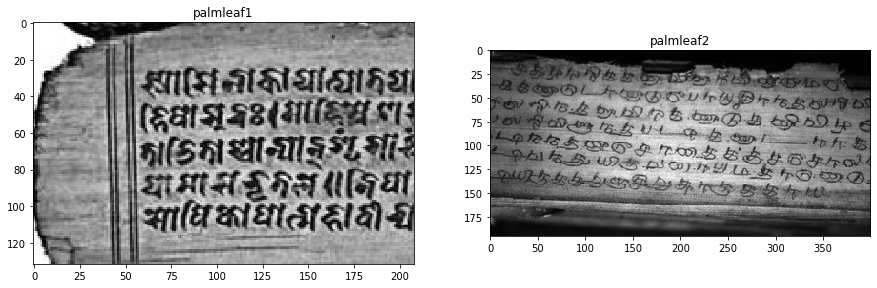

In [3]:
# Read the images
img1 = cv2.imread('palmleaf1.pgm',0)
img2 = cv2.imread('palmleaf2.pgm',0)

# Plot the images
f, axs = plt.subplots(1, 2, figsize = (15,8))
axs[0].imshow(img1,cmap='gray')
axs[0].set_title("palmleaf1")
axs[1].imshow(img2,cmap='gray')
axs[1].set_title("palmleaf2")


Text(0.5, 1.0, 'palmleaf2')

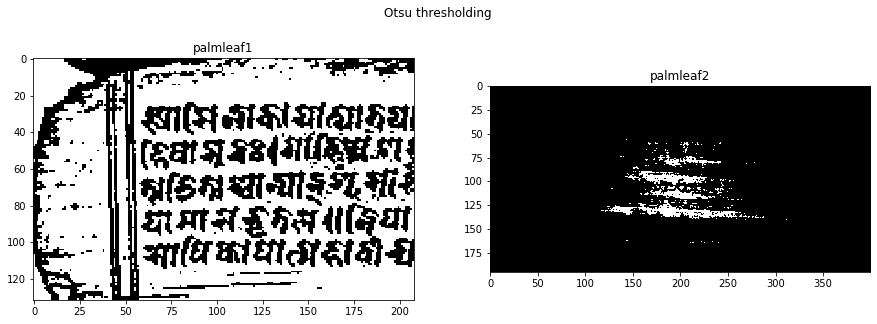

In [4]:
# Obtain thresholded images for palmleaf1 and palmleaf2
thresh_img1 = otsu_threshold(img1)
thresh_img2 = otsu_threshold(img2)

# Plot the images
f, axs = plt.subplots(1, 2, figsize = (15,5))
plt.suptitle("Otsu thresholding")
axs[0].imshow(thresh_img1,cmap='gray')
axs[0].set_title("palmleaf1")
axs[1].imshow(thresh_img2,cmap='gray')
axs[1].set_title("palmleaf2")


We can see the output after Otsu thresholding for palmleaf1 is quite good while the output for palmleaf2 is very bad. This is because pamleaf1 is almost uniformly illuminated while palmleaf2 has a lot of variation in illumination. Otsu thresholding is a global thresholding technique and hence is not robust to illumination variation. Therefore, other techniques which involve local thresholding are required to obtain better thresholding outputs for palmleaf2.

# Question 2

In [5]:
# K-Means function
# Used to determine K mean vectors which are the cluster centers. myu_init is the arbitrary initialistion 
# given for the initial cluster centers. We also limit the maximum number of iterations to find the clusters. 
def kmeans(X, myu_init, max_iter = 300):
  myu = myu_init.copy()
  K = len(myu)

  # prev_i_star contains the cluster numbers of all the vectors.
  prev_i_star = np.array([-1]*X.shape[0])

  # For each point 'n' in the input data, Z[n,k] is 1 if the point n is in the k-th cluster. Otherwise it is assigned 0.
  Z = np.empty([X.shape[0], K],dtype=int)
  step=0

  while True:
    # A point in the input is in cluster i if it's closest to that cluster center as compared to other centers.
    i_star = np.array([np.argmin([np.linalg.norm(x_vec-myu_i) for myu_i in myu]) for x_vec in X])
    if np.array_equal(prev_i_star,i_star) or step>max_iter:
      # print('Finished Kmeans. # iterations : '+str(step))
      break
    for n in range(X.shape[0]):
      for i in range(K):
        Z[n,i] = 1 if i==i_star[n] else 0
    
    num_clus = np.sum(Z, axis=0) # number of examples in each cluster
    # Compute the new cluster centers to be the mean of all vectors assigned to that cluster.
    myu = np.array([np.sum([Z[n,i]*X[n] for n in range(X.shape[0])], axis = 0)/num_clus[i] if num_clus[i]>0 else np.zeros(X.shape[-1]) for i in range(K)])
    prev_i_star = np.copy(i_star)
    step = step + 1
  
  return myu # Dimension will be K*d

# Obtain the K-Means filtered image from the original image using the above function.
# Each pixel is assigned the cluster center that it's closest to.
def get_kmeans_img(img,myu):
  output_img = np.zeros(img.shape)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      output_img[i,j] = myu[np.argmin([np.linalg.norm(img[i,j]-myu_i) for myu_i in myu])]

  return np.int32(output_img)


Text(0.5, 1.0, 'Flower')

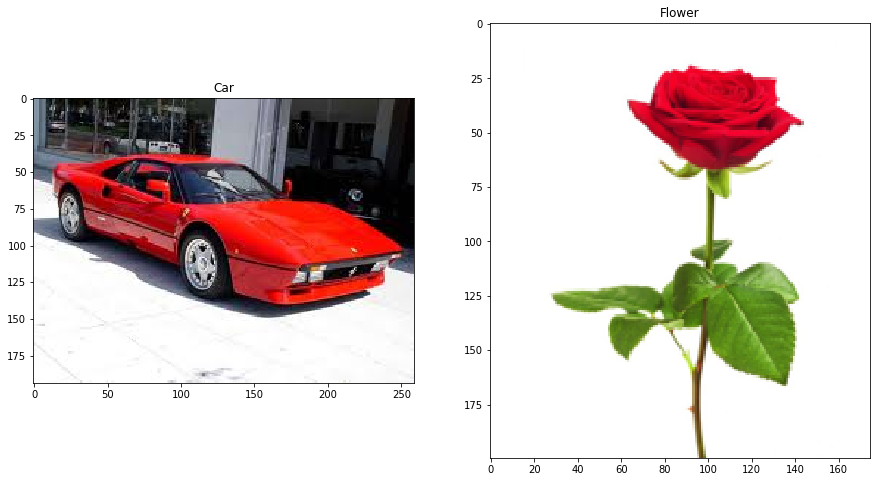

In [6]:
# Read both the images
img1 = cv2.imread('car.ppm')
img2 = cv2.imread('flower.png')

# Convert both the RGB format since cv2.imread reads it in BGR format
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

# Plot the images
f, axs = plt.subplots(1, 2, figsize = (15,8))
axs[0].imshow(img1)
axs[0].set_title("Car")
axs[1].imshow(img2)
axs[1].set_title("Flower")

## Part a

Here we try KMeans with the given initial values to cluster centers.

In [7]:
# Initial cluster centers
myu_init = np.array([[255,0,0],[0,0,0],[255,255,255]])

# Compute Kmeans filtered images for image1
myu1 = kmeans(img1.reshape(-1,3), myu_init)
kmeans_img1 = get_kmeans_img(img1, myu1)

# Compute Kmeans filtered images for image2
myu2 = kmeans(img2.reshape(-1,3), myu_init)
kmeans_img2 = get_kmeans_img(img2, myu2)


Text(0.5, 1.0, 'Flower')

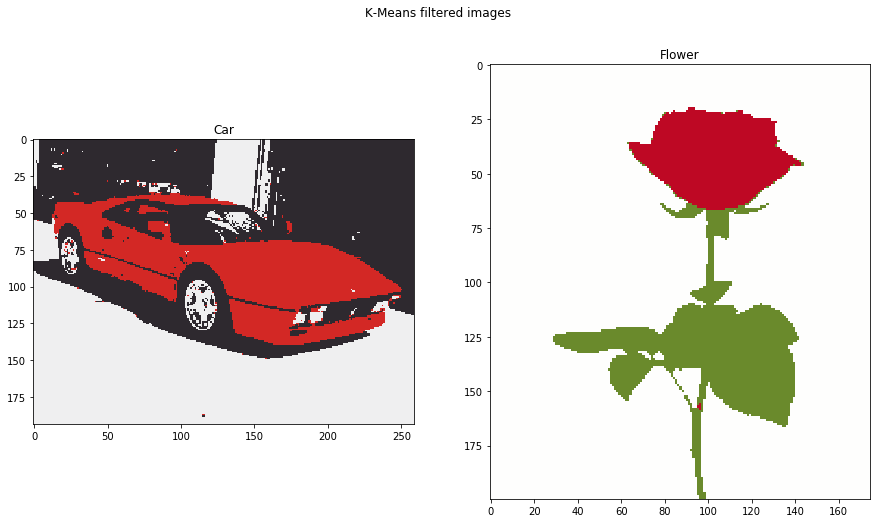

In [8]:
# Plot the images
f, axs = plt.subplots(1, 2, figsize = (15,8))
plt.suptitle('K-Means filtered images')
axs[0].imshow(kmeans_img1)
axs[0].set_title("Car")
axs[1].imshow(kmeans_img2)
axs[1].set_title("Flower")

The filter is clearly able to differentiate between the 3 main colours present in the images.

## Part b

We define cost corresponding to the output of KMeans as $C = \sum_{i=1}^{P} dist(p_i,c_k)$ where dist measures the Euclidean distance between a pixel color value $p_i$ and its cluster center $c_k$ , and P refers to the total number of pixels in the image.

In [9]:
# Compute the cost of the output as defined above.
def compute_cost(img, myu):
    cost = 0.
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            myu_ij = myu[np.argmin([np.linalg.norm(img[i,j]-myu_i) for myu_i in myu])]
            cost += np.linalg.norm(img[i,j]-myu_ij)

    return cost

In [10]:
# KMeans with random initialisations
def kmeans_with_random_initialisation(img, N = 30):
    # Initialise min and max cost and their corresponding cluster centers.
    min_cost = 1.0e16
    min_myu = None
    max_cost = 0.0
    max_myu = None


    reshaped_img = img.reshape(-1,3)
    for n in tqdm(range(N)):
        # print(f"Iteration {n+1}")
        myu_init = np.random.randint(256,size=(3,3))
        myu_i = kmeans(reshaped_img, myu_init)
        # Compute the cost corresponding to each random initialisation.
        # Find the cluster centers(myu) corresponding to lowest and highest value of cost.
        myu_i_cost = compute_cost(img, myu_i)
        if myu_i_cost < min_cost:
            min_cost = myu_i_cost
            min_myu = myu_i
        
        if myu_i_cost > max_cost:
            max_cost = myu_i_cost
            max_myu = myu_i
    
    # Return the cluster centers(myu) corresponding to minimum and maximum value of cost.
    return min_myu, max_myu       
    

In [11]:
# Compute myu for car and flower images corresponding to min and max cost.
min_myu1, max_myu1 = kmeans_with_random_initialisation(img1, N=30)
min_myu2, max_myu2 = kmeans_with_random_initialisation(img2, N=30)

# Obtain KMeans filtered images for car and flower images.
min_img1 = get_kmeans_img(img1, min_myu1)
max_img1 = get_kmeans_img(img1, max_myu1)

min_img2 = get_kmeans_img(img2, min_myu2)
max_img2 = get_kmeans_img(img2, max_myu2)


100%|██████████| 30/30 [04:29<00:00,  8.99s/it]


Text(0.5, 1.0, 'Flower with maximum cost')

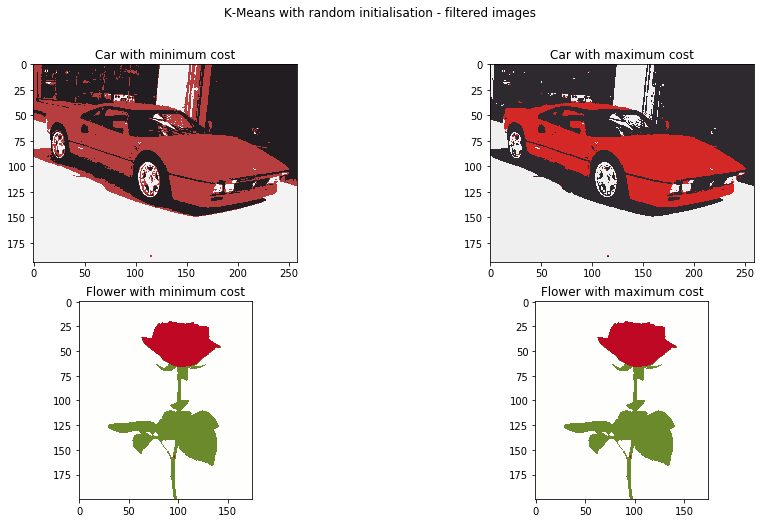

In [12]:
# Plot the images
f, axs = plt.subplots(2, 2, figsize = (15,8))
plt.suptitle('K-Means with random initialisation - filtered images')
axs[0,0].imshow(min_img1)
axs[0,0].set_title("Car with minimum cost")
axs[0,1].imshow(max_img1)
axs[0,1].set_title("Car with maximum cost")
axs[1,0].imshow(min_img2)
axs[1,0].set_title("Flower with minimum cost")
axs[1,1].imshow(max_img2)
axs[1,1].set_title("Flower with maximum cost")


We notice that the images corresponding to minimum and maximum cost for the car is slightly different while it is exactly the same for the flower. This is probably because the image of the car had a lot of different colours while the flower comprised only of 3 colours. Since the three colours of the flower were clearly differentiable, the initialisation of cluster centers did not matter for the flower. On the other hand, there was a lot of variation in the colours of the car image in the background. Therefore, clusters were not clearly differentiable and different initialisations produced different results.